In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("../data/ETTh1.csv")
df['date'] = pd.to_datetime(df['date'])

# Separate features helps us to identify whether anomalies are driven by load or temperature
electical_features = ['HUFL', 'MUFL', 'LUFL']
thermal_features = ['OT']

X_initial = df[thermal_features].values

scaler = StandardScaler()
X = scaler.fit_transform(X_initial)

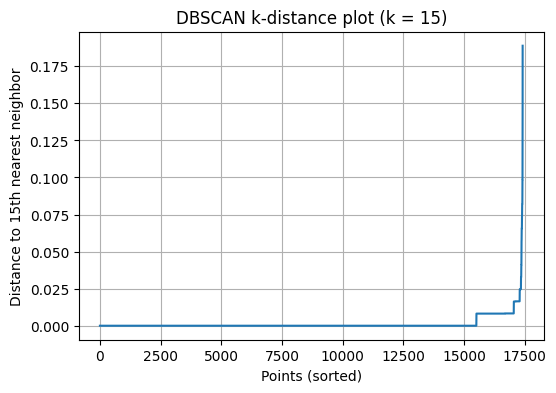

In [2]:
# We are trying to find the ideal value of epsilon in this block of code.

k = 15
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(X)

distances, _ = nbrs.kneighbors(X)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.xlabel("Points (sorted)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("DBSCAN k-distance plot (k = 15)")
plt.grid()
plt.show()

{-1: 57, 0: 17105, 1: 111, 2: 147}
Total anomalies detected: 57
The noise ratio is:  0.0032721010332950632 %


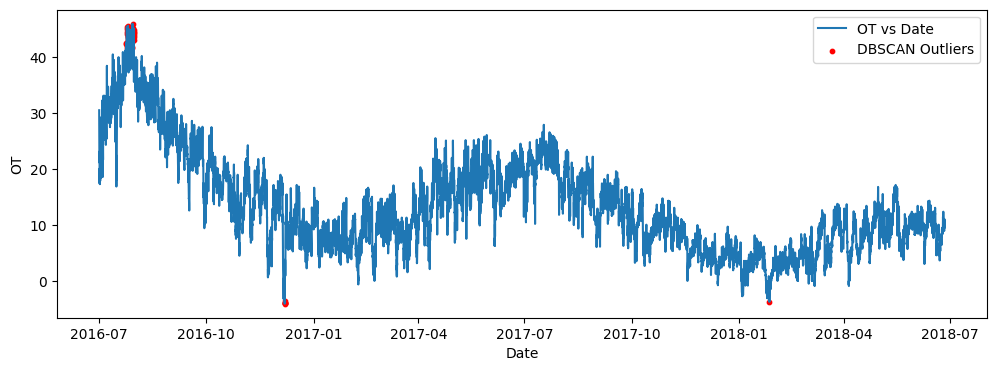

In [5]:
clustering = DBSCAN(eps=0.025, min_samples=k)    # Based on the graph.
clustering.fit(X)
df['cluster'] = clustering.labels_

# Finding the number of clusters formed
unique, counts = np.unique(df['cluster'], return_counts=True)
print(dict(zip(unique, counts)))

# Number of anomalies
n_outliers = (df['cluster'] == -1).sum()
print(f"Total anomalies detected: {n_outliers}")

# Noise ratio
noise_ratio = np.mean(df['cluster'] == -1)
print('The noise ratio is: ', noise_ratio, '%')

# Plotting the outliers
plt.figure(figsize = (12,4))
plt.plot(df['date'], df['OT'], label = 'OT vs Date')

plt.scatter(
    df.loc[df['cluster'] == -1, 'date'], df.loc[df['cluster'] == -1, 'OT'], color='red', s=10, label='DBSCAN Outliers'
)
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

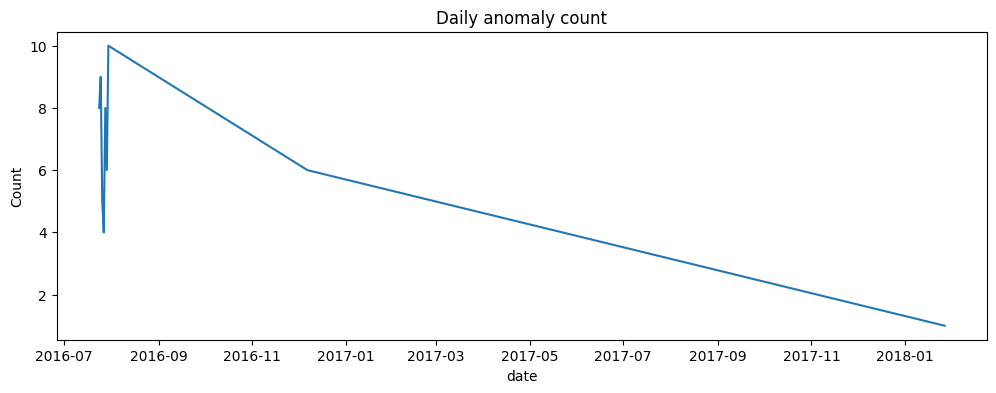

In [6]:
daily_anomalies = df[df['cluster'] == -1].groupby(df['date'].dt.date).size()

plt.figure(figsize=(12,4))
daily_anomalies.plot()
plt.title("Daily anomaly count")
plt.ylabel("Count")
plt.show()